In [1]:
# Data analysis packages:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f'%x)
#from datetime import datetime as dt

# Visualization packages:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# import plotly.graph_objs as go 
%matplotlib inline

# Import all necessary libraries.

import warnings
# import plots as p
import function as f
# import data_testing as dt
# import data_prep as dp

import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime as dt
from IPython.display import HTML # to see everything
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

Energy savings has two keys elements:
- forecasting energy consumption without any energy saving measures 
- forecasting energy consumption after certain energy saving measures

This notebook predict 

# Dataset:

In [16]:
# training data
train = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
train_weather = pd.read_csv("data/weather_train.csv", parse_dates=['timestamp'])
metadata = pd.read_csv("data/building_metadata.csv")

print('Size of training data', train.shape)
print('Mem. size of original training data', np.round(train.memory_usage().sum()/1024**2, 2))
print('----------------------------------')
print('Size of training weather data', weather_train.shape)
print('Mem. size of original training weather data', np.round(weather_train.memory_usage().sum()/1024**2, 2))
print('----------------------------------')
print('Size of building meta data', metadata.shape)
print('Mem. size of original building meta data', np.round(metadata.memory_usage().sum()/1024**2, 2))

# df.memory_usage().sum() / 1024**2 

Size of training data (20216100, 4)
Mem. size of original training data 616.95
----------------------------------
Size of training weather data (139773, 9)
Mem. size of original training weather data 9.6
----------------------------------
Size of building meta data (1449, 6)
Mem. size of original building meta data 0.07


## Files
train.csv
> - **building_id** - Foreign key for the building metadata.
- **meter** - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter types.
- **timestamp** - When the measurement was taken
- **meter_reading** - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. #### building_meta.csv  

metadata.csv
> - **site_id** - Foreign key for the weather files.
- **building_id** - Foreign key for training.csv
- **primary_use** - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- **square_feet** - Gross floor area of the building
- **year_built** - Year building was opened
- **floorcount** - Number of floors of the building #### weather[train/test].csv Weather data from a meteorological station as close as possible to the site.  

Weather_train.csv
> **site_id**  
**timestamp** - When the measurement was taken  
**air_temperature** - Degrees Celsius  
**cloud_coverage** - Portion of the sky covered in clouds, in oktas  
**dew_temperature** - Degrees Celsius  
**precip_depth_1_hr** - Millimeters  
**sea_level_pressure** - Millibar/hectopascals  
**wind_direction** - Compass direction (0-360)  
**wind_speed** - Meters per second

## Reducing memory

In [17]:
## Reducing memory
train = f.reduce_mem_usage(train)
# train_df.to_csv(r'data\train_reduced.csv')
print('Mem. size of reduced training data', train.shape)
print('----------------------------------')
train_weather = f.reduce_mem_usage(train_weather)
# weather_train_df.to_csv(r'data\weather_train_reduced.csv')
print('Mem. size of reduced training weather data', train_weather.shape)
print('----------------------------------')
metadata = f.reduce_mem_usage(metadata)
# metadata_train_df.to_csv(r'data\metadata_train_reduced.csv')
print('Mem. size of reduced building meta data', metadata.shape)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. size of reduced training data (20216100, 4)
----------------------------------
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. size of reduced training weather data (139773, 9)
----------------------------------
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. size of reduced building meta data (1449, 6)


In [18]:
# Thera are four differnt meter information
f.feat_value_count(train, 'meter')

,meter_values,counts
0,0,12060910
1,1,4182440
2,2,2708713
3,3,1264037


***there are 15 different site_ids***

# Training data : Exploratory Data Analysis (EDA)
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data.

## Checking missing data for train_df

In [19]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing__train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data

,Total,Percent
meter_reading,0,0.000
timestamp,0,0.000
meter,0,0.000
building_id,0,0.000


## Checking missing values for weather_train_df

In [13]:
total = weather_train_df.isnull().sum().sort_values(ascending=False)
percent = (weather_train_df.isnull().sum()/weather_train_df.isnull().count()*100).sort_values(ascending=False)
missing__weather_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__weather_data

,Total,Percent
cloud_coverage,69173,49.490
precip_depth_1_hr,50289,35.979
sea_level_pressure,10618,7.597
wind_direction,6268,4.484
wind_speed,304,0.217
dew_temperature,113,0.081
air_temperature,55,0.039
timestamp,0,0.000
site_id,0,0.000


## Checking missing values for Metadata_train_df

In [14]:
total = metadata_train_df.isnull().sum().sort_values(ascending=False)
percent = (metadata_train_df.isnull().sum()/metadata_train_df.isnull().count()*100).sort_values(ascending=False)
missing__metadata_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__metadata_data

,Total,Percent
floor_count,1094,75.500
year_built,774,53.416
square_feet,0,0.000
primary_use,0,0.000
building_id,0,0.000
site_id,0,0.000


# Ploting Training set

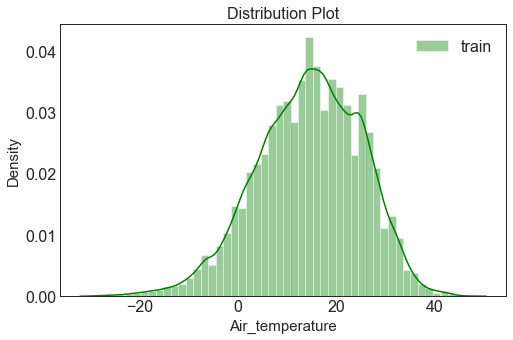

In [28]:
import visualization_1 as vis
vis.plot_dist_col(weather_train_df)

In [ ]:
np.unique(metadata_train_df[metadata_train_df['primary_use']=='Education']['site_id'], return_counts=True)

In [ ]:
metadata_train_df.groupby(by='Eduction')
#     metadata_train_df.primary_use.value_counts()

## Weather data

In [ ]:
print(weather_train_df.shape)
weather_train_df.head(3)

# Checking missing values 

In [ ]:
# train_df.isna().sum()/len(train_df)

In [ ]:
# metadata_train_df.isna().sum()#/len(building_meta_df)

In [ ]:
# weather_train_df.isna().sum()#/len(weather_train_df)

In [ ]:
weather_train_df.loc[0::8784]

In [ ]:
unique_site_id = np.unique(weather_train_df['site_id'])

print(unique_site_id)
# site_list = [weather_train_df[x] for x in unique_site_id if weather_train_df['site_id']==x]
# site_list
df_list = []
for i in unique_site_id:
    df_list.append(weather_train_df[weather_train_df['site_id']==i])

In [ ]:
df_0= df_list[0]
len(df_list)
type(df_list)
df_0.head()

In [ ]:
def interpolated(df):
    df_on = df.set_index('timestamp')
#     print(df.head())
    df_on = df_on.interpolate(method='time')
    df_on = df_on.reset_index()
    
    return df_on

In [ ]:
df_0_int = interpolated(df_0)

In [ ]:
df_list[0]

In [ ]:
weather_train_df[weather_train_df['site_id']==0].info()

In [ ]:
sample_df = weather_train_df[weather_train_df['site_id']==0]
sample_df.head()
site_list = 
for df in 

In [ ]:
sample_df.set_index('timestamp', inplace=True)

In [ ]:
sample_df.interpolate(method='time').isna().sum()

In [ ]:
# checking the 'nan' columns 
nan_cols = [i for i in sample_df.columns if sample_df[i].isnull().any()]
sample_df.fillna(-200, inplace=True)
nan_cols

In [ ]:
sample_df.head()

In [ ]:
# print(nan_cols)
for j in nan_cols:
    for i in range(0, len(sample_df)):
#         sample_df[j].fillna(sample_df[i-1])#, inplace=True)
        if sample_df[j][i] == -200:
            print("yes")
            sample_df[j][i] = sample_df[j][i-1]

In [ ]:
sample_df.head()

In [ ]:
# missing value treatment 
# cols = sample_df.columns
# cols[['air_temperature', 'cloud_coverage', 'dew_temperature']]
# col_lst = ['air_temperature', 'cloud_coverage', 'dew_temperature']


In [ ]:
sample_df.head()

In [ ]:
cols = sample_df.columns
for i in cols:
    
    sample_df['i'].fillna(sample_df.groupby(by=[sample_df.timestamp.dt.day, sample_df.timestamp.dt.month])['i'].mean()
                          #     metadata['year_built'].fillna(-999, inplace=True)
# sample_df.groupby(by=[sample_df.timestamp.dt.day, sample_df.timestamp.dt.month]).mean()

# .agg(['max', 'mean', 'median', 'count', 'std'])
#  df['day_of_month'] = df['timestamp'].dt.day.astype("uint8")

In [ ]:
sample_df.groupby(by=[sample_df.timestamp.dt.day, sample_df.timestamp.dt.month])['air_temperature'].mean()

In [ ]:
sample_df.head()

# Replacing meter's

In [ ]:
print(train_df['meter'].value_counts())

In [ ]:
train_df['meter'].replace({0:"Electricity",1:"ChilledWater", 2:"Steam",3:"HotWater"}, inplace=True)
train_df['meter'].value_counts()

In [ ]:
import seaborn as sns 
sns.set(style='darkgrid')
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_context('talk')
sns.countplot(train_df['meter'], order=train_df['meter'].value_counts().index)
plt.title('Distribution of Meter Id Code')
plt.xlabel('Meter Id Code')
plt.ylabel('Frequency');

In [ ]:
print ("There are {} unique Buildings in the training data".format(train_df['building_id'].nunique()))

Like it is mentioned in the competition description, each building may or may not have all 4 meter

In [ ]:
train_df.groupby('meter')['meter_reading'].agg(['min','max','mean','median', 'count', 'std'])

## Building Metadata:

In [ ]:
# metadata
sns.countplot(building_meta_df['primary_use'], order=building_meta_df['primary_use'].value_counts().index)
plt.title('Distribution of Primary use of Buildings')
plt.xlabel('Building types')
plt.ylabel('Frequency');

In [ ]:
# Building floor count
sns.countplot(building_meta_df['floor_count'], order=building_meta_df['floor_count'].value_counts().index)
plt.title('Floor counts')
plt.xlabel('Floors')
plt.ylabel('Frequency');

In [ ]:
# year built 
sns.countplot(building_meta_df['year_built'], order=building_meta_df['year_built'].value_counts().index)
plt.title('Year built')
plt.xlabel('Years')
plt.ylabel('Frequency');

In [ ]:
# fig = px.scatter(metadata, y="square_feet", x="year_built", color="primary_use", size="square_feet")
# fig.update_layout(showlegend=True)
# fig.show()

In [ ]:
for df in [train_df]:
    df['month'] = df['timestamp'].dt.month.astype("uint8")
    df['day_of_month'] = df['timestamp'].dt.day.astype("uint8")
    df['day_of_week'] = df['timestamp'].dt.dayofweek.astype("uint8")
    df['hour'] = df['timestamp'].dt.hour.astype("uint8")

In [ ]:
def split_timestamp(df):
    df['month'] = df['timestamp'].dt.month.astype('uint8')
    df['day_of_month'] = df['timestamp'].dt.day.astype('uint8')
    df['day_of_week'] = df['timestamp'].dt.dayofweek.astype('uint8')
    df['hour'] = df['timestamp'].dt.hour.astype('uint8')
    
    return df

### Grouping by meter and month

In [ ]:
train_df = split_timestamp(train_df)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_df.groupby(['meter', 'month'])['meter_reading'].agg(['max', 'mean', 'median', 'count', 'std'])

In [ ]:
train.drop(columns=['Month', 'DayOfMonth', 'DayOfWeek', 'Hour'], inplace=True)
train.head(1)

In [ ]:
train_df.groupby(['meter', 'day_of_week'])['meter_reading'].agg(['max', 'mean', 'median', 'count', 'std'])

In [ ]:
sns.distplot(np.log1p(train_df['meter_reading']), kde=False)
plt.title('Distribution of log of meter reading variable')

In [ ]:
sns.boxplot(train_df[train_df['meter'] == "Electricity"]['meter_reading']);
plt.title("Boxplot of Meter Reading Variable for the Meter Type: Electricity");
# We can see a few outliers here. 

In [ ]:
sns.boxplot(train_df[train_df['meter'] == "ChilledWater"]['meter_reading']);
plt.title("Boxplot of Meter Reading Variable for the Meter Type: ChilledWater");
# Not many outliers here.

In [ ]:
sns.boxplot(train_df[train_df['meter'] == "HotWater"]['meter_reading']);
plt.title("Boxplot of Meter Reading Variable for the Meter Type: HotWater");
# We can see a single value that is way off from the rest. 

In [ ]:
sns.boxplot(train_df[train_df['meter'] == "Steam"]['meter_reading']);
plt.title("Boxplot of Meter Reading Variable for the Meter Type: Steam");
# We can see a few outliers here. 

### Converting the dependent variable to logarithmic scale

In [ ]:
train_df.head()

In [ ]:
train_df['meter_reading'] = np.log1p(train_df['meter_reading'])
train_df.head()

In [ ]:
sns.distplot(train_df[train_df['meter'] == "Electricity"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Electricity")

In [ ]:
sns.distplot(train_df[train_df['meter'] == "ChilledWater"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Chilledwater")

In [ ]:
sns.distplot(train_df[train_df['meter'] == "Steam"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Steam")

In [ ]:
sns.distplot(train_df[train_df['meter'] == "HotWater"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Hotwater")

In [ ]:
train_df.head(3)

## Metadata 

In [ ]:
building_meta_df.info()
# Missing values in year_built and floor_count variables

In [ ]:
building_meta_df.head(3)

In [ ]:
cols = ['site_id','primary_use','year_built','floor_count','building_id']
for col in cols:
    print ("Number of Unique Values in the {} column are:".format(col),building_meta_df[col].nunique())

In [ ]:
cols = ['site_id','primary_use','floor_count']
for col in cols:
    print ("Unique Values in the {} column are:".format(col),building_meta_df[col].unique())
    print ("\n")

In [ ]:
sns.countplot(building_meta_df['site_id'])
plt.title("Count of Site_id in the Metadata table")
plt.xlabel("Site_Id")
plt.ylabel("Count")

In [ ]:
plt.figure(figsize=(8,6))
building_meta_df['primary_use'].value_counts().sort_values().plot(kind='bar')
plt.title("Count of Primary_Use Variable in the Metadata table")
plt.xlabel("Primary Use")
plt.ylabel("Count")
plt.xticks(rotation=90);
# Education, Office, Entertainment/Public Assembly, Public Services, Lodging/Residential form the bulk of Primary Use

In [ ]:
building_meta_df['square_feet'].describe()

In [ ]:
sns.boxplot(building_meta_df['square_feet']);

In [ ]:
building_meta_df['square_feet'] = np.log1p(building_meta_df['square_feet'])

In [ ]:
sns.distplot(building_meta_df['square_feet'])
plt.title("Distribution of Square Feet variable of Metadata Table")
plt.xlabel("Area in Square Feet")
plt.ylabel("Frequency");
# Looks like a normal distribution distribution

In [ ]:
sns.boxplot(building_meta_df['square_feet'])
plt.title("Box Plot of Square Feet Variable");
# There are a few outliers visible

In [ ]:
building_meta_df.groupby('primary_use')['square_feet'].agg(['mean','median','count']).sort_values(by='count')
# Parking has the highest average are although the count is less.
# Education has the highest count as can be seen in the countplot above.

In [ ]:
building_meta_df['year_built'].value_counts().sort_values().plot(kind='bar',figsize=(15,6))
plt.xlabel("Year Built")
plt.ylabel("Count")
plt.title("Distribution of Year Built Variable");

In [ ]:
building_meta_df['floor_count'].value_counts(dropna=False).sort_index().plot(kind='bar',figsize=(8,6))
plt.xlabel("Number of Floors")
plt.ylabel("Count of Buildings");
# Lot of missing values here as well
# Maximum number of floors is 26

In [ ]:
building_meta_df.groupby('floor_count')['square_feet'].agg(['count','mean','median']).sort_values(by='count')

In [ ]:
building_meta_df.groupby('primary_use')['square_feet'].agg(['count','mean','median']).sort_values(by='count')

In [ ]:
metadata['year_built'].fillna(-999, inplace=True)
metadata['year_built'] = metadata['year_built'].astype('int16')
metadata['floor_count'].fillna(-999, inplace=True)
metadata['floor_count'] = metadata['floor_count'].astype('float32')

In [ ]:
metadata.head(3)

## Weather Data (Train)

In [ ]:
weather_train_df.head(3)

In [ ]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    print (" Minimum Value of {} column is {}".format(col,weather_train[col].min()))
    print (" Maximum Value of {} column is {}".format(col,weather_train[col].max()))
    print ("----------------------------------------------------------------------")

In [ ]:
weather_train_df.isna().sum()/len(weather_train_df)

In [ ]:
weather_train_df[['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']].describe()

In [ ]:
print(weather_train['timestamp'].min())
print(weather_train['timestamp'].max())
print(len( weather_train['timestamp']))
# This data is from 1st Jan to 31st Dec 2016, similar to the timestamp of the training data

In [ ]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.distplot(weather_train[col].dropna())

In [ ]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.boxplot(weather_train[col].dropna())

# Merging Data

In [ ]:
train.head(3)

In [ ]:
metadata.head(3)

In [ ]:
weather_train.dtypes

In [ ]:
train.columns
train_df.columns

In [ ]:
import gc
from time import time 
# %%time
train_data = pd.merge(train_df,building_meta_df,on='building_id',how='left')
# test  = pd.merge(test,metadata,on='building_id',how='left')
print ("Training Data Shape {}".format(train_data.shape))
# print ("Testing Data Shape {}".format(test.shape))
gc.collect()

In [ ]:

train_data.dtypes

In [ ]:
# %%time
train = pd.merge(train_data,weather_train,on=['site_id','timestamp'],how='left')
# test  = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
print ("Training Data Shape {}".format(train.shape))
# print ("Testing Data Shape {}".format(test.shape))
# gc.collect()

In [ ]:
train.head(3)

In [ ]:

cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    train[col].fillna(train[col].mean(),inplace=True)
#     test[col].fillna(test[col].mean(),inplace=True)
    
del metadata, weather_train#, weather_test

In [ ]:
train.columns

In [ ]:
# %%time
for df in [train]:#, test]:
    df['weekend'] = np.where((df['day_of_week'] == 5) | (df['day_of_week'] == 6), 1, 0)
    df['air_temperature'] = df['air_temperature'].astype('float16')
    df['cloud_coverage'] = df['cloud_coverage'].astype("float16")
    df['dew_temperature'] = df['dew_temperature'].astype('float16')
    df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype('float32')
    df['sea_level_pressure'] = df['sea_level_pressure'].astype('float32')
    df['wind_direction'] = df['wind_direction'].astype('float32')
    df['wind_speed'] = df['wind_speed'].astype('float16')
    df['square_feet'] = df['square_feet'].astype("float32")
    df['building_id'] = df['building_id'].astype("int16")